# MNIST Testing

In [52]:
# In order to force reload any changes done to the models package files
%load_ext autoreload
%autoreload 2

In [126]:
from torchvision.datasets import MNIST
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
import umap
import torch
from torch.utils.data import DataLoader
from torchvision.transforms.v2 import PILToTensor,Compose
import matplotlib.pyplot as plt
import numpy as np

# Allow import from our custom lib python files
import sys
import os

module_path = os.path.abspath(os.path.join('../src/mnist-dits'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Get and inspect data

In [75]:
from dataset import MNIST

mnist_dit = MNIST(is_train=False, root="../Data")

In [58]:
mnist_pt = MNIST(root="../Data", download=True)
mnist = fetch_openml(name="mnist_784", data_home="../Data/", cache=True)

In [61]:
dataloader = DataLoader(mnist_pt, batch_size=1, shuffle=False, num_workers=5)

In [37]:
X = mnist["data"].to_numpy()
y = mnist["target"].astype(int).to_numpy()

X.shape, y.shape, mnist_pt[0][0]

((70000, 784), (70000,), <PIL.Image.Image image mode=L size=28x28>)

## Train and load MNIST transformer

### Train

Takes a while, probably should be done in the terminal seperately. Had to modify `train.py` from [MNIST-DiTs](https://github.com/owenliang/mnist-dits) heavily to get it to work.

In [73]:
%%bash
# Train
cd ../src/mnist-dits/
python train.py

### Load

In [123]:
from dit import DiT
from config import T

device ='cuda' if torch.cuda.is_available() else 'cpu'
model = DiT(img_size=28,patch_size=4,channel=1,emb_size=64,label_num=10,dit_num=3,head=4).to(device)
model.load_state_dict(torch.load('../src/mnist-dits/model.pth', map_location=torch.device(device)))

model

DiT(
  (conv): Conv2d(1, 16, kernel_size=(4, 4), stride=(4, 4))
  (patch_emb): Linear(in_features=16, out_features=64, bias=True)
  (time_emb): Sequential(
    (0): TimeEmbedding()
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
  )
  (label_emb): Embedding(10, 64)
  (dits): ModuleList(
    (0-2): 3 x DiTBlock(
      (gamma1): Linear(in_features=64, out_features=64, bias=True)
      (beta1): Linear(in_features=64, out_features=64, bias=True)
      (alpha1): Linear(in_features=64, out_features=64, bias=True)
      (gamma2): Linear(in_features=64, out_features=64, bias=True)
      (beta2): Linear(in_features=64, out_features=64, bias=True)
      (alpha2): Linear(in_features=64, out_features=64, bias=True)
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (wq): Linear(in_features=64, out_features=256, bias=True)
   

### Model output

In [128]:
def get_attn_weights(model, idx):
    img, label = mnist_dit[idx]
    x=(img*2-1)[None, :] # Why?
    # x=img
    torch.full((x.size(0),),T-1)
    # t=torch.randint(0,T,(img.size(0),))  # Whyyy
    y=torch.tensor(label)

    model.eval()
    model.train(False)
    model(x, t, y)

    return [model.dits[0].attn.detach().numpy(), model.dits[1].attn.detach().numpy(), model.dits[2].attn.detach().numpy()]

## Dimensionality reduction

### UMAP

In [33]:
input_2d = umap.UMAP(n_neighbors=15, random_state=42, metric='euclidean', n_components=2).fit_transform(X)
input_2d

/Users/bjonnalagadda/.pyenv/versions/3.10.0/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


array([[ 5.89401   ,  8.096252  ],
       [15.637076  ,  5.8550253 ],
       [ 0.63387537, 14.696931  ],
       ...,
       [-2.1681218 , 14.107217  ],
       [ 4.381559  , 10.110127  ],
       [11.106793  ,  5.797195  ]], dtype=float32)

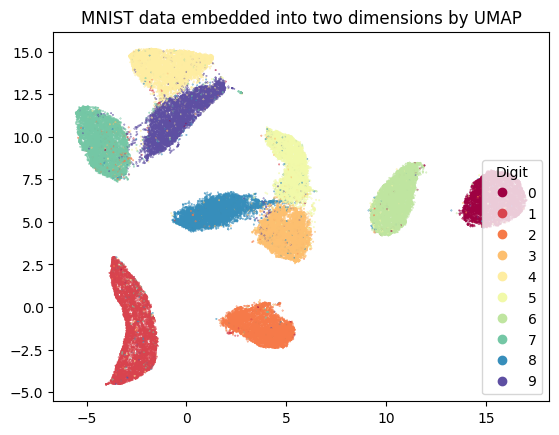

In [46]:
fig = plt.scatter(input_2d[:,0], input_2d[:,1], c=y, cmap="Spectral", s=0.1, label=y)
plt.legend(*fig.legend_elements(), loc="lower right", title="Digit")
plt.title('MNIST data embedded into two dimensions by UMAP')
plt.show()

### t-SNE

In [48]:
input_2d_tsne = TSNE(n_components=2, n_iter=1000, init='pca').fit_transform(X)

/Users/bjonnalagadda/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/bjonnalagadda/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


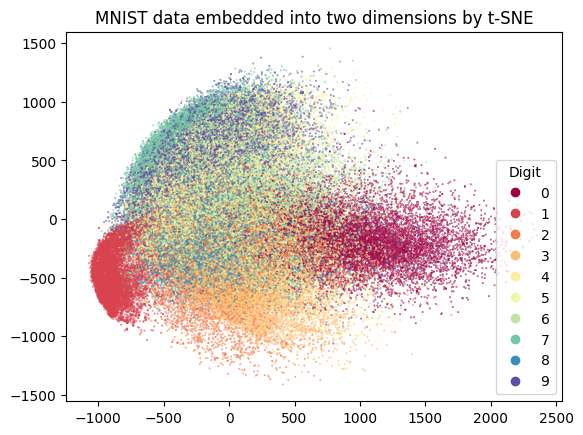

In [49]:
fig = plt.scatter(input_2d_tsne[:,0], input_2d_tsne[:,1], c=y, cmap="Spectral", s=0.1, label=y)
plt.legend(*fig.legend_elements(), loc="lower right", title="Digit")
plt.title('MNIST data embedded into two dimensions by t-SNE')
plt.show()

## Attention

In [129]:
def show_attns(attns, idx):

    plt.imshow(mnist_pt[idx][0])
    print(mnist_pt[idx][1])
        
    fig, axs = plt.subplots(3, 4)
    
    for i in range(len(attns)):
        axs[i, 0].imshow(attns[i][0, 0, :, :])
        axs[i, 1].imshow(attns[i][0, 1, :, :])
        axs[i, 2].imshow(attns[i][0, 2, :, :])
        axs[i, 3].imshow(attns[i][0, 3, :, :])
        
    plt.show()


In [148]:
attns[0].shape

(1, 4, 49, 49)

5


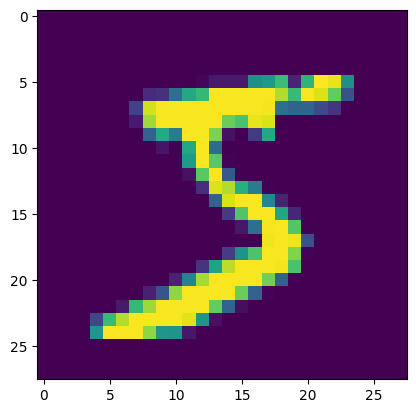

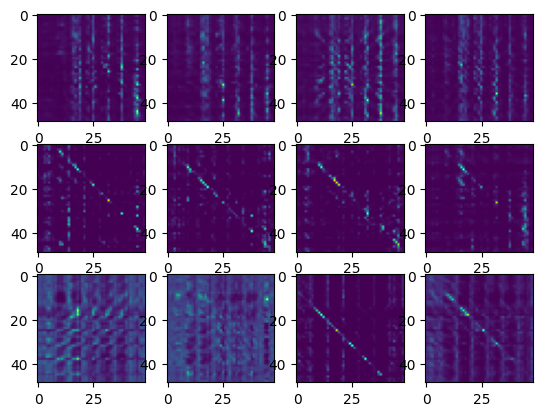

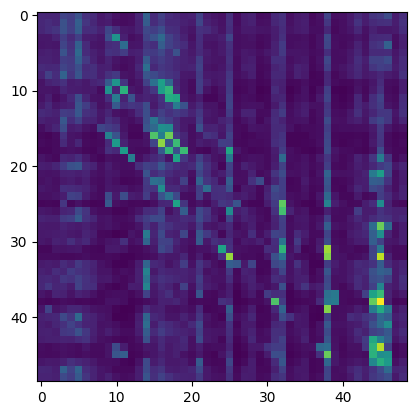

In [145]:
idx = 0
attns = get_attn_weights(model, idx)
show_attns(attns, idx)
plt.imshow(np.mean(np.array(attns), axis=(0, 1, 2)))

4


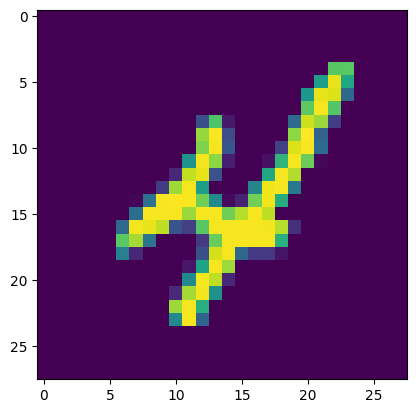

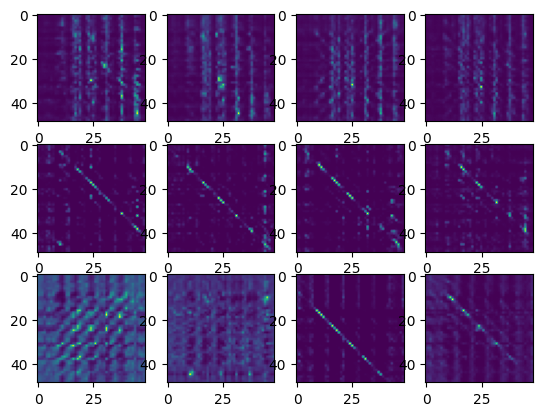

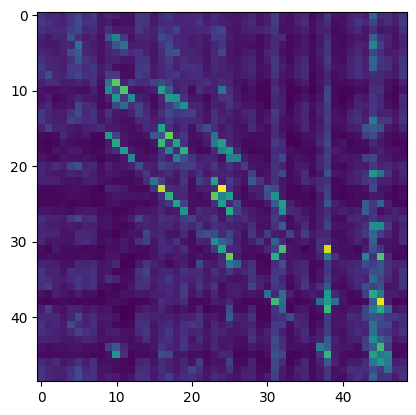

In [146]:
idx = 9
attns = get_attn_weights(model, idx)
show_attns(attns, idx)
plt.imshow(np.mean(np.array(attns), axis=(0, 1, 2)))

0


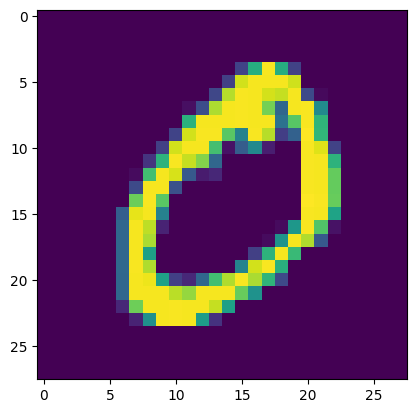

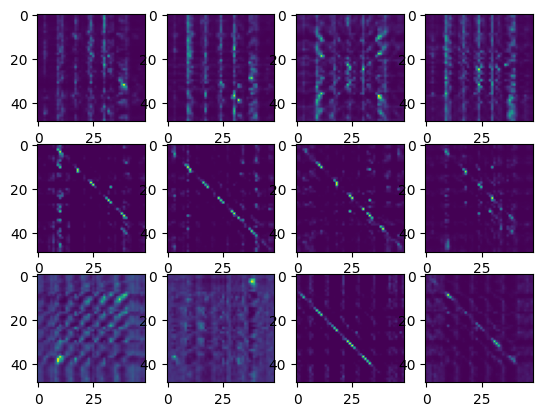

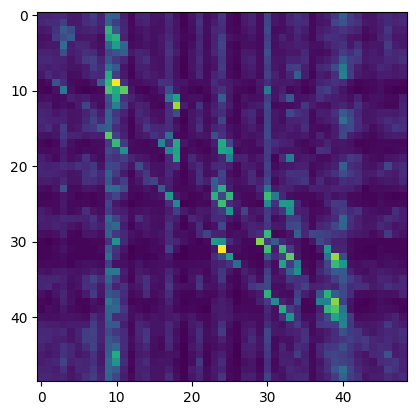

In [147]:
idx = 1
attns = get_attn_weights(model, idx)
show_attns(attns, idx)
plt.imshow(np.mean(np.array(attns), axis=(0, 1, 2)))

## BERTViz

In [ ]:
torch.nn.functional.multi_head_attention_forward